<a href="https://colab.research.google.com/github/jahidhasan299/jahidhasan299-Deep-Learning-With-7-Real-Projects/blob/main/3D_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code uses 3D Unet to train a network on 3D subvolumes (64x64x64).
It also segments a large volume and outputs a multidimensional OMETIFF file.<p>
Custom dataset is used for this code but it should work on any dataset.
<p>

In [1]:
# Building Unet by dividing encoder and decoder into blocks
#This is exactly the same unet used in earlier exercises for 2D images.
#Except here we change conv2D to conv3D, Maxpooling2D to Maxpooling3D
#upsampling2D to upsampling3D and Conv2DTranspose to Conv3DTranspose.
#We also change the filter size and pooling sizes from 3x3 and 2x2 to
# 3x3x3 and 2x2x2, respectively. 

from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv3D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv3D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling3D((2, 2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv3DTranspose(num_filters, (2, 2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv3D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [2]:
my_model = build_unet((64,64,64,3), n_classes=4)

softmax


In [3]:
print(my_model.summary())

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 64, 64, 64,   5248        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64,   256        ['conv3d[0][0]']                 
 alization)                     64)                                                           

In [4]:
my_model.input_shape

(None, 64, 64, 64, 3)

In [5]:
#Use patchify to break large volumes into smaller for training 
#and also to put patches back together after prediction.
!pip install patchify

In [6]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


In [7]:
#Make sure the GPU is available. 
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [8]:
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
#Load input images and masks. 
#Here we load 256x256x256 pixel volume. We will break it into patches of 64x64x64 for training. 
image = io.imread('/content/drive/MyDrive/Colab Notebooks/datasets/sandstone_data_for_ML 2/data_for_3D_Unet/train_images_256_256_256.tif')
img_patches = patchify(image, (64, 64, 64), step=64)  #Step=64 for 64 patches means no overlap

mask = io.imread('/content/drive/MyDrive/Colab Notebooks/datasets/sandstone_data_for_ML 2/data_for_3D_Unet/train_masks_256_256_256.tif')
mask_patches = patchify(mask, (64, 64, 64), step=64)  


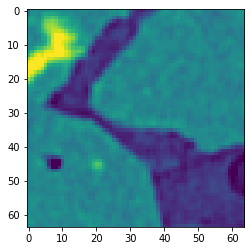

In [11]:
plt.imshow(img_patches[1,2,3,:,:,32])
#

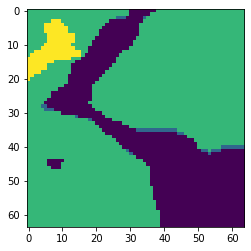

In [12]:
plt.imshow(mask_patches[1,2,3,:,:,32])

In [13]:
input_img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))

print(input_img.shape)  # n_patches, x, y, z



(64, 64, 64, 64)


In [14]:
n_classes=4

In [15]:
#Convert grey image to 3 channels by copying channel 3 times.
#We do this as our unet model expects 3 channel input. 

train_img = np.stack((input_img,)*3, axis=-1)
train_img = train_img / 255. 
train_mask = np.expand_dims(input_mask, axis=4)

train_mask_cat = to_categorical(train_mask, num_classes=n_classes)

X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat, test_size = 0.10, random_state = 0)

In [16]:
# Loss Function and coefficients to be used during training:
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


In [17]:
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense

In [18]:
#Define parameters for our model.

patch_size = 64
channels=3

LR = 0.0001
optim = Adam(LR)


In [19]:
model = build_unet((patch_size,patch_size,patch_size,channels), n_classes=n_classes)

softmax


In [20]:
model.compile(optimizer = optim, loss=dice_coefficient_loss, metrics=dice_coefficient)
print(model.summary())

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv3d_19 (Conv3D)             (None, 64, 64, 64,   5248        ['input_2[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization_18 (BatchN  (None, 64, 64, 64,   256        ['conv3d_19[0][0]']              
 ormalization)                  64)                                                           

In [21]:
print(model.input_shape)
print(X_train.shape)
print(model.output_shape)
print(y_train.shape)
print("-------------------")
print(X_train.max())  #Shpuld be 1 after scaling. If it shows 255, go back and normalize/scale inputs


(None, 64, 64, 64, 3)
(57, 64, 64, 64, 3)
(None, 64, 64, 64, 4)
(57, 64, 64, 64, 4)
-------------------
1.0


In [22]:
#Fit the model
history=model.fit(X_train, 
          y_train,
          batch_size=8, 
          epochs=120,
          verbose=1,
          validation_data=(X_test, y_test))

Epoch 1/120
8/8 [==============================] - 73s 5s/step - loss: 0.4786 - dice_coefficient: 0.5287 - val_loss: 0.7513 - val_dice_coefficient: 0.2487
Epoch 2/120
8/8 [==============================] - 28s 3s/step - loss: 0.3111 - dice_coefficient: 0.6931 - val_loss: 0.7432 - val_dice_coefficient: 0.2568
Epoch 3/120
8/8 [==============================] - 27s 3s/step - loss: 0.2486 - dice_coefficient: 0.7439 - val_loss: 0.7084 - val_dice_coefficient: 0.2916
Epoch 4/120
8/8 [==============================] - 27s 3s/step - loss: 0.2128 - dice_coefficient: 0.7884 - val_loss: 0.6675 - val_dice_coefficient: 0.3325
Epoch 5/120
8/8 [==============================] - 27s 3s/step - loss: 0.1901 - dice_coefficient: 0.7975 - val_loss: 0.6177 - val_dice_coefficient: 0.3823
Epoch 6/120
8/8 [==============================] - 27s 3s/step - loss: 0.1753 - dice_coefficient: 0.8217 - val_loss: 0.5703 - val_dice_coefficient: 0.4297
Epoch 7/120
8/8 [==============================] - 27s 3s/step - loss:

In [23]:
#Save model for future use
model.save('/content/drive/MyDrive/Colab Notebooks/models/sandstone_3D_120epochs.h5')

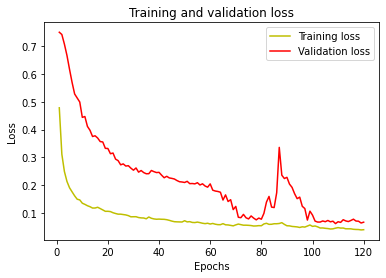

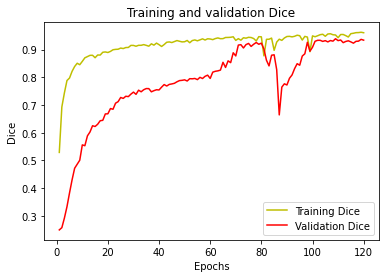

In [24]:
###
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_coefficient']
val_acc = history.history['val_dice_coefficient']

plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [25]:
#Load the pretrained model for testing and predictions. 
from keras.models import load_model
my_model = load_model('/content/drive/MyDrive/Colab Notebooks/models/sandstone_3D_100epochs.h5', compile=False)
#If you load a different model do not forget to preprocess accordingly. 

In [26]:
#Predict on the test data
y_pred=my_model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=4)
y_test_argmax = np.argmax(y_test, axis=4)


In [27]:
print(y_pred_argmax.shape)
print(y_test_argmax.shape)
print(np.unique(y_pred_argmax))

(7, 64, 64, 64)
(7, 64, 64, 64)
[0 1 2 3]


In [28]:
#Using built in keras function for IoU
#Only works on TF > 2.0
from keras.metrics import MeanIoU
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.7543529


In [29]:
#Test some random images
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)


test_pred = my_model.predict(test_img_input)
test_prediction = np.argmax(test_pred, axis=4)[0,:,:,:]

ground_truth_argmax = np.argmax(ground_truth, axis=3)
print(ground_truth_argmax.shape)

(64, 64, 64)


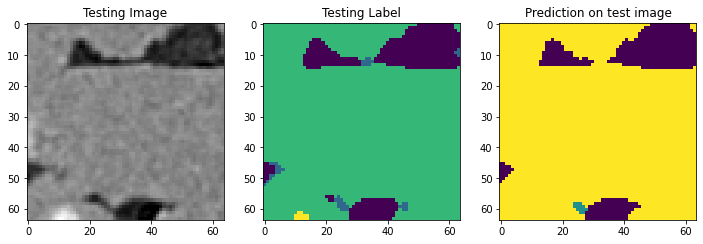

In [35]:
#Plot individual slices from test predictions for verification
slice = random.randint(0, ground_truth_argmax.shape[2]-1)
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[slice,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_argmax[slice,:,:])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction[slice,:,:])
plt.show()

Now segment the full volume using the trained model.

In [36]:
#Break the large image (volume) into patches of same size as the training images (patches)
large_image = io.imread('/content/drive/MyDrive/Colab Notebooks/datasets/sandstone_data_for_ML 2/data_for_3D_Unet/448_images_512x512.tif')
patches = patchify(large_image, (64, 64, 64), step=64)  #Step=256 for 256 patches means no overlap
print(large_image.shape)
print(patches.shape)

(448, 512, 512)
(7, 8, 8, 64, 64, 64)


In [37]:
# Predict each 3D patch   
predicted_patches = []
for i in range(patches.shape[0]):
  for j in range(patches.shape[1]):
    for k in range(patches.shape[2]):
      #print(i,j,k)
      single_patch = patches[i,j,k, :,:,:]
      single_patch_3ch = np.stack((single_patch,)*3, axis=-1)
      single_patch_3ch = single_patch_3ch/255.
      single_patch_3ch_input = np.expand_dims(single_patch_3ch, axis=0)
      single_patch_prediction = my_model.predict(single_patch_3ch_input)
      single_patch_prediction_argmax = np.argmax(single_patch_prediction, axis=4)[0,:,:,:]
      predicted_patches.append(single_patch_prediction_argmax)
      


In [38]:
#Convert list to numpy array
predicted_patches = np.array(predicted_patches)
print(predicted_patches.shape)

(448, 64, 64, 64)


In [39]:
#Reshape to the shape we had after patchifying
predicted_patches_reshaped = np.reshape(predicted_patches, 
                                        (patches.shape[0], patches.shape[1], patches.shape[2],
                                         patches.shape[3], patches.shape[4], patches.shape[5]) )
print(predicted_patches_reshaped.shape)

(7, 8, 8, 64, 64, 64)


In [40]:
#Repach individual patches into the orginal volume shape
reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
print(reconstructed_image.shape)

(448, 512, 512)


In [41]:
print(reconstructed_image.dtype)

int64


In [42]:
#Convert to uint8 so we can open image in most image viewing software packages
reconstructed_image=reconstructed_image.astype(np.uint8)
print(reconstructed_image.dtype)

uint8


In [44]:
#Now save it as segmented volume.
from tifffile import imsave
imsave('/content/drive/MyDrive/Colab Notebooks/datasets/sandstone_data_for_ML 2/data_for_3D_Unet/448_images_segmented.tif', reconstructed_image)
    

In [45]:
#If you would like to save the volume as multichannel dataset....

In [46]:
print(np.unique(reconstructed_image))

[0 1 2 3]


In [47]:
#Seperate each channel/segment to be combined as multiple channels.
num_segments=4
segm0 = (reconstructed_image == 0)
segm1 = (reconstructed_image == 1)
segm2 = (reconstructed_image == 2)
segm3 = (reconstructed_image == 3)

final = np.empty((reconstructed_image.shape[0], reconstructed_image.shape[1], reconstructed_image.shape[2], num_segments))
final[:,:,:,0] = segm0
final[:,:,:,1] = segm1
final[:,:,:,2] = segm2
final[:,:,:,3] = segm3

In [48]:
#Use APEER OMETIFF library to read and write multidimensional images
!pip install apeer-ometiff-library

In [49]:
from apeer_ometiff_library import io

In [50]:
# Expand image array to 5D of order (T, Z, C, X, Y)
# This is the convention for OMETIFF format as written by APEER library
final = np.expand_dims(final, axis=0)
final=np.swapaxes(final, 2, 4)

final = final.astype(np.int8)



In [51]:
print("Shape of the segmented volume is: T, Z, C, X, Y ", final.shape)
print(final.dtype)


Shape of the segmented volume is: T, Z, C, X, Y  (1, 448, 4, 512, 512)
int8


In [53]:
# Write dataset as multi-dimensional OMETIFF *image*
io.write_ometiff("/content/drive/MyDrive/Colab Notebooks/datasets/sandstone_data_for_ML 2/data_for_3D_Unet/448_segmented_multi_channel.ome.tiff", final)

You can view multichannel images for free on: www.apeer.com <p>